In [1]:
# Required libraries
# Required libraries
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
from pathlib import Path
import sys
import os 
import pandas as pd
import numpy as np
from itertools import chain
import matplotlib.pyplot as plt
import datetime
import zipfile 
from timeit import default_timer as timer
import sqlalchemy as db
# Paths
sys.path.append(os.path.join(Path(os.getcwd()).parent))  
data_path = os.path.join(os.path.join(Path(os.getcwd()).parent), 'data')
data_per_day_path = os.path.join(os.path.join(Path(os.getcwd()).parent), 'data','data_per_day')
results_path = os.path.join(os.path.join(Path(os.getcwd()).parent), 'results')

# create connection to sqlite database
db_path = os.path.join(data_path, 'database.db')
db_engine = db.create_engine('sqlite:///' + db_path)

In [2]:
# get the data folders file now
data_folders = [f for f in os.listdir(data_per_day_path) if not os.path.isfile(os.path.join(data_per_day_path, f))]
data_folders = [file for file in data_folders if '.' not in file]
data_folders = [os.path.join(data_per_day_path, x) for x in data_folders]
data_folders = [data_folders[0], data_folders[1], data_folders[3]]

In [3]:
def compute_RV(data_df, resample):
    RV = []
    for resampling in resample:
        # resample data 
        df_resampled = data_df.resample(resampling).ffill()
        #df_resampled = df_resampled.append(pd.DataFrame(data_df[-1:].values, 
        #                                                    index=[df_resampled.index[-1] + datetime.timedelta(minutes=10)],columns=data_df.columns)) # get last observation that is not added by ffill
        df_resampled['RET'] = df_resampled.MID.pct_change().apply(np.vectorize(lambda x: np.log(1+x)))
        df_resampled.dropna(inplace=True)
        RV.append(df_resampled.RET.apply(lambda x: x**2).sum())
    return RV

In [4]:
def get_rv(csv_file):
    resample = ['1s', '10s', '30s', '1min', '5min', '10min', '15min', '20min','25min' '30min','35min', '40min', '45min', '50min', '60min']
    data_df = pd.read_csv(csv_file)
    data_df.DT = pd.to_datetime(data_df.DT)
    data_df.sort_values(by=['DT'], inplace=True)
    data_df.index = data_df.DT
    data_df.drop(columns=['DT'],inplace=True)
    data_df = data_df.between_time('9:30', '16:00')
    data_df.reset_index(drop=False, inplace=True)

    # non zero quotes
    data_df = data_df.loc[(data_df.BID>0) & (data_df.BIDSIZ>0) & (data_df.ASK>0) & (data_df.ASKSIZ>0)]

    # autoselect exchange
    data_df['total_size'] = data_df.BIDSIZ + data_df.ASKSIZ
    data_df = data_df.loc[data_df.EX == data_df.groupby(['EX']).sum().total_size.idxmax()]

    # delete negative spreads
    data_df = data_df.loc[data_df.ASK > data_df.BID]

    # mergeQuotesSameTimestamp
    ex = data_df.EX.values[0]
    sym_root = data_df.SYM_ROOT.values[0]
    data_df.drop(columns=['SYM_SUFFIX', 'total_size'], inplace=True)
    data_df = data_df.groupby(['DT']).median()
    data_df['EX'] = ex
    data_df['SYM_ROOT'] = sym_root
    data_df.reset_index(drop=False, inplace=True)

    # remove entries with spread > 50 * daily median spread
    data_df['SPREAD'] = data_df.ASK - data_df.BID
    data_df = data_df.loc[data_df['SPREAD'] < 50 * data_df['SPREAD'].median()]

    # remove outliers using the centered rolling window approach 
    def compute_diff(x):
        return x.values[window] - np.median(np.delete(x.values,window))

    window = 25
    data_df.sort_values(by=['DT'], inplace=True)
    data_df['SPREAD_DIFF'] = data_df.SPREAD.rolling(2*window+1, min_periods=2*window+1, center=True).apply(compute_diff)
    data_df = data_df.dropna()
    data_df = data_df.loc[data_df['SPREAD_DIFF'] < 10 * data_df['SPREAD_DIFF'].mean()]
    data_df = data_df.reset_index(drop=True)
    
    data_df.set_index(['DT'], inplace=True)
    data_df["MID"] = data_df.apply(lambda x: (x.ASK * x.ASKSIZ + x.BID * x.BIDSIZ) / (x.ASKSIZ + x.BIDSIZ), axis=1)
    data_df = data_df[['MID', 'SYM_ROOT']]
    return compute_RV(data_df, resample)

In [5]:
%%time
from joblib import Parallel, delayed
resample = ['1s', '10s', '30s', '1min', '5min', '10min', '15min', '20min','25min' '30min','35min', '40min', '45min', '50min', '60min']
vol_signature = []
for data_folder in data_folders:
    # get the csv file now
    table_name = data_folder[-3:]
    csv_files = [f for f in os.listdir(data_folder) if os.path.isfile(os.path.join(data_folder, f))]
    csv_files = [file for file in csv_files if '.csv' in file]
    csv_files = np.sort([os.path.join(data_folder, x) for x in csv_files])
    RV= Parallel(n_jobs=14)(delayed(get_rv)(i) for i in csv_files)
    RV_av = np.mean(RV,axis=0)
    vol_signature.append(RV_av)

CPU times: user 1.1 s, sys: 57.6 ms, total: 1.16 s
Wall time: 26min 45s


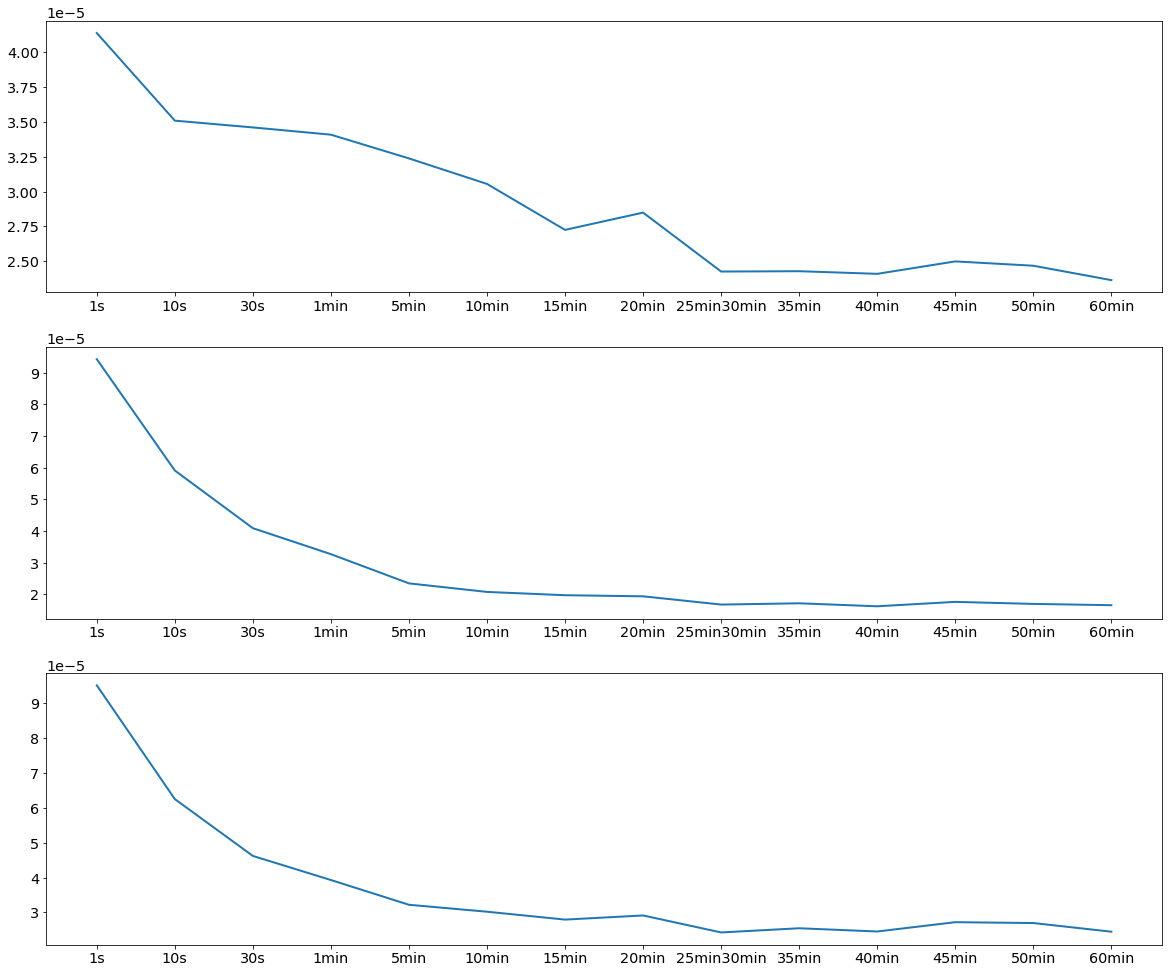

In [13]:
import matplotlib.pylab as pylab
params = {
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

fig, axs = plt.subplots(3, 1, figsize=(20, 17))
for i in range(len(vol_signature)):
    axs[i].plot(resample, vol_signature[i],linewidth=2)

plt.savefig(os.path.join(results_path, 'vol_signature.png'), dpi=400, facecolor='aliceblue', edgecolor='k',bbox_inches='tight')
plt.show()